> Reference: Boosting Adversarial Attacks with Momentum: https://arxiv.org/abs/1710.06081

# Momentum Iterative Method (MIM)
## 2. Backgrounds

Adversarial attacks aim to create input samples that are misclassified by classifiers. These attacks can be non-targeted, where the perturbed input is misclassified as any incorrect label, or targeted, where it is misclassified as a specific incorrect label. The perturbation is typically small and bound by an \(L_p\) norm.

### 2.1. Attack methods

There are three main categories for generating adversarial examples:

- **One-step gradient-based methods:** Methods like Fast Gradient Sign Method (FGSM) use the gradient of the loss to create adversarial examples.
- **Iterative methods:** These methods apply the gradient method multiple times with a small step size, improving the strength of the attack at the cost of transferability.
- **Optimization-based methods:** These methods optimize the adversarial examples directly, often using techniques like L-BFGS.

### 2.2. Defense methods

Adversarial training is the primary method for increasing model robustness against adversarial examples, especially through techniques like ensemble adversarial training, which uses adversarial examples generated from multiple models.

## 3. Methodology

The Momentum Iterative Method (MIM) introduces momentum into iterative FGSM to create adversarial examples. It combines the advantages of iterative and momentum-based methods, increasing the transferability and strength of the attacks.

### 3.1. Momentum iterative fast gradient sign method

This method uses a velocity vector to stabilize gradient updates over iterations, helping to escape poor local optima and improving the attack's effectiveness.

**Algorithm: MI-FGSM**

```plaintext
Input: Classifier, loss function, initial example, label, perturbation size, iterations, decay factor
Output: Adversarial example within specified \(L_\infty\) norm
1: Initialize step size and velocity vector
2: For each iteration, compute gradient, update velocity and apply it
3: Return final adversarial example


In [ ]:
! pip install ultralytics

In [18]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image



# Step 1: Load trained YOLOv8 model
model = YOLO('train/weights/best.pt')
image_path = 'stop.png'

# Step 2: Extract the backbone (CSPDarknet53)
backbone = model.model.model[:10]
labels = torch.tensor([22])

num_classes = 29
sample_image = torch.randn(1, 3, 416, 416)  # Adjust size if necessary
sample_output = backbone(sample_image)
output_channels = sample_output.shape[1]
classify_model = nn.Sequential(
    backbone,  # Use the CSPDarknet53 backbone
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce to (batch_size, channels, 1, 1)
    nn.Flatten(),  # Flatten to (batch_size, channels)
    nn.Linear(in_features=output_channels, out_features=num_classes)  # Linear layer for classification
)

preprocess = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize to 416x416
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

image = Image.open(image_path).convert("RGB")  # Load image and ensure it's in RGB format
image = preprocess(image).unsqueeze(0)  # Apply preprocessing and add batch dimension

In [19]:
# Momentum Iterative Method (MIM) Integration
import torch
import torch.nn.functional as F

def mi_fgsm(model, x, y, epsilon, alpha, iterations, decay_factor):
    """
    Perform Momentum Iterative Fast Gradient Sign Method (MI-FGSM) attack.

    Args:
        model: The target model to be attacked.
        x: Original input image (tensor).
        y: True label of the input image (tensor).
        epsilon: Maximum perturbation allowed.
        alpha: Step size for each iteration.
        iterations: Number of iterations.
        decay_factor: Momentum decay factor.

    Returns:
        adv_x: Adversarial example generated.
    """
    # Initialize the adversarial example as the original image
    adv_x = x.clone().detach()
    adv_x.requires_grad = True  # Set requires_grad to True initially
    # Initialize the gradient accumulation term
    accumulated_grad = torch.zeros_like(x)

    for i in range(iterations):
        # Forward pass through the model
        output = model(adv_x)
        # Calculate the loss using cross-entropy
        loss = F.cross_entropy(output, y)
        # Zero all gradients
        model.zero_grad()
        # Backward pass to get the gradient of the loss w.r.t. the input image
        loss.backward()
        # Get the gradient of the current iteration
        grad = adv_x.grad.clone().detach()  # Clone and detach to avoid inference tensor issue
        # Accumulate the gradient with momentum
        accumulated_grad = decay_factor * accumulated_grad + grad / torch.sum(torch.abs(grad), dim=(1, 2, 3), keepdim=True)
        # Update the adversarial example by applying the sign of the accumulated gradient
        adv_x = adv_x.detach() + alpha * torch.sign(accumulated_grad)
        # Clip the adversarial example to ensure it's within the allowed epsilon range
        adv_x = torch.clamp(adv_x, x - epsilon, x + epsilon)
        adv_x = torch.clamp(adv_x, 0, 1)  # Ensure pixel values are in [0, 1]
        adv_x.requires_grad = True  # Re-enable requires_grad for next iteration

    return adv_x

# Example Usage
# Assuming you already have variables `model`, `x`, `y`, `epsilon`, `alpha`, and `iterations` defined
# decay_factor = 1.0 could be used as a default, or tune based on experiments
# adv_example = mi_fgsm(model, x, y, epsilon=0.03, alpha=0.01, iterations=10, decay_factor=1.0)

# Note: The above code can be used seamlessly in the existing FGSM and I-FGSM implementation.
perturbed_image = mi_fgsm(classify_model, image, labels, epsilon=0.03, alpha=0.01, iterations=10, decay_factor=1.0)
# perturbed_image = mi_fgsm(classify_model, image, labels, epsilon=0.3, alpha=0.02, iterations=50, decay_factor=1.0)

In [20]:
def get_yolo_output(model, image):
    results = model(image)
    return results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls

perturbed_image = torch.clamp(perturbed_image, 0, 1)
image = torch.clamp(image, 0, 1)
boxes, scores, labels = get_yolo_output(model, image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(model, perturbed_image)



0: 416x416 1 Stop_Sign, 63.9ms
Speed: 0.0ms preprocess, 63.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Stop_Sign, 58.6ms
Speed: 0.0ms preprocess, 58.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


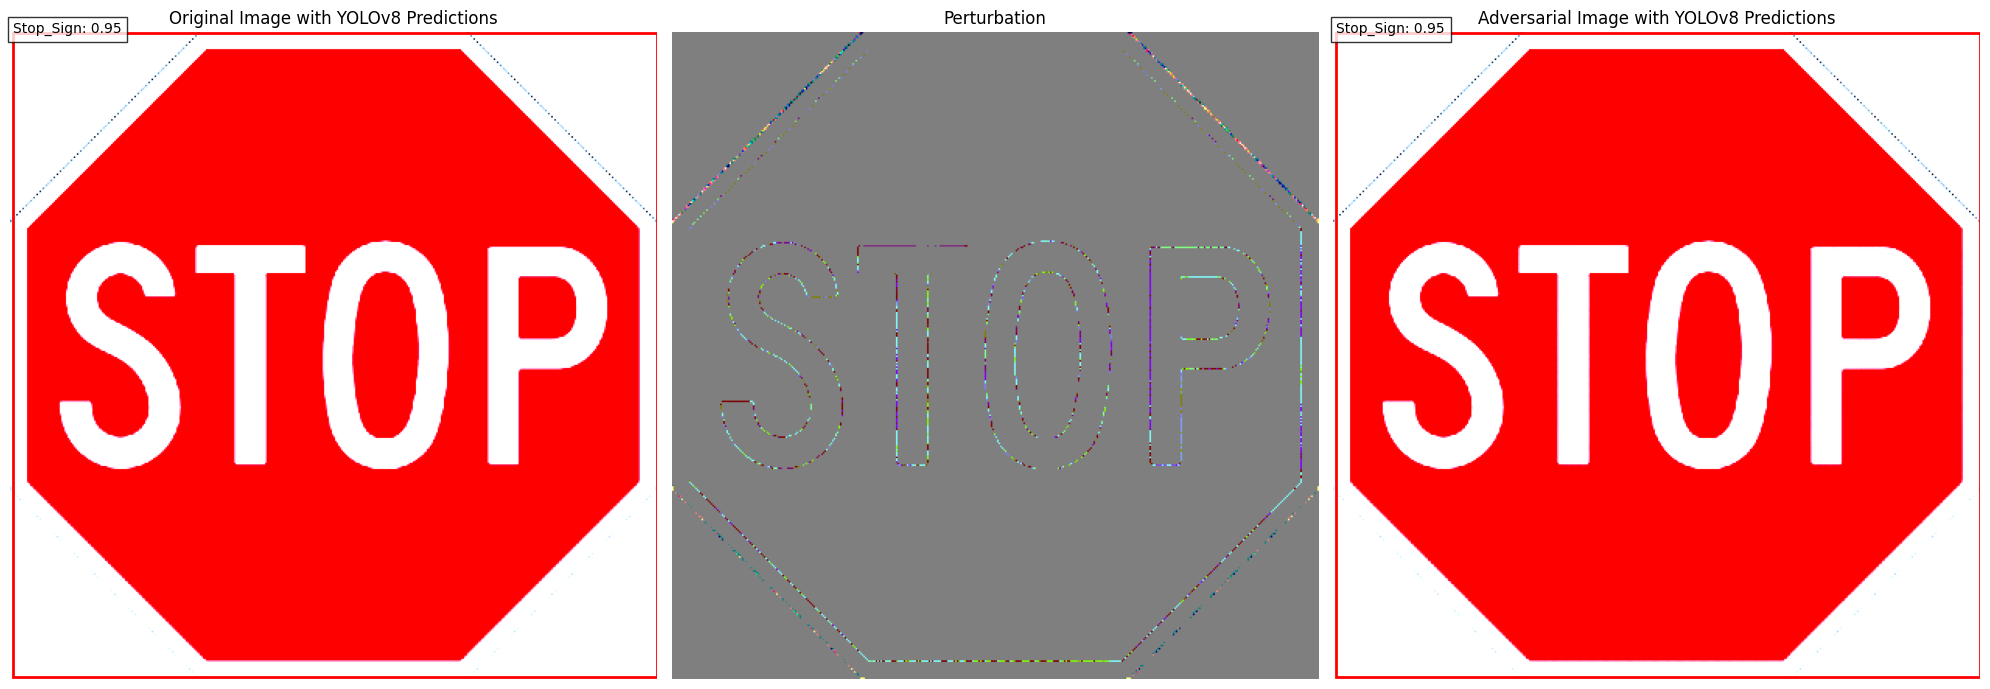

In [21]:
import matplotlib.pyplot as plt

def plot_boxes(ax, boxes, scores, labels, title, image_tensor):
    # Detach, remove batch dimension, permute to (height, width, channels), and convert to NumPy
    ax.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{model.names[int(label)]}: {score:.2f}", bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image)

# Perturbation
perturbation = (perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image)

plt.tight_layout()
plt.show()
